In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.functional as F
import torch.nn as nn

import torch.optim as optim


%matplotlib inline                               


In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
batch_size = 8
workers = 0
data_dir = 'data/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.Resize(512),
                                      transforms.CenterCrop(512),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                                     ])
                            
data_transform = transforms.Compose([transforms.Resize(512),
                                     transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                                    ])

train_data = datasets.ImageFolder(train_dir, train_transform)
valid_data = datasets.ImageFolder(valid_dir, data_transform)
test_data = datasets.ImageFolder(test_dir, data_transform)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=workers, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


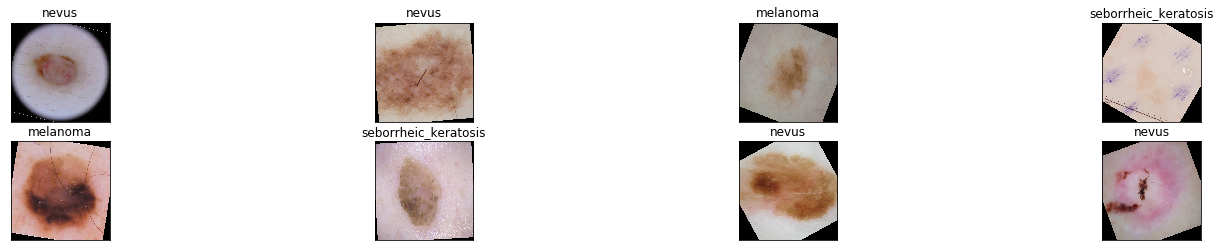

In [4]:
# Visualize some sample data

classes = train_data.classes

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    image = np.array([0.229, 0.224, 0.225]) * image + np.array([0.485, 0.456, 0.406])
    plt.imshow(image)
    ax.set_title(classes[labels[idx]])

In [5]:
vgg16 = models.vgg16(pretrained=True)

In [6]:
karims_model = vgg16
karims_model.classifier[-1] = nn.Linear(4096, 3)

In [7]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

In [8]:
if train_on_gpu:
    karims_model.load_state_dict(torch.load("pretrained_vgg16_train_all_parameters_skin_cancer.pt", map_location=torch.device('gpu')))
else:
    karims_model.load_state_dict(torch.load("pretrained_vgg16_train_all_parameters_skin_cancer.pt", map_location=torch.device('cpu')))

In [9]:
epochs = 10 
valid_loss_min = 0
save_path = 'pretrained_vgg16_train_all_parameters_skin_cancer.pt'

if train_on_gpu:
    karims_model = karims_model.cuda()

for i, (data, label) in enumerate(valid_loader):
    torch.cuda.empty_cache()
    if train_on_gpu:
        data, label = data.cuda(), label.cuda()
    output = karims_model(data)
    loss = criterion(output, label)
    valid_loss_min += (loss.item() - valid_loss_min) / (i+1)
    print("*", end="")
print(f"\n\nSetting valid_loss_min at ", valid_loss_min)
with open("debug", "a") as f:
            f.write("Setting valid_loss_min at "+str(round(valid_loss_min,6)))

for e in range(1, epochs+1):
    train_loss = 0. 
    valid_loss = 0.
    karims_model.train()
    print("Training")
    with open("debug", "a") as f:
            f.write("\nTraining\n")
    for i, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        if train_on_gpu:
            data, label = data.cuda(), label.cuda()
        output = karims_model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step
        train_loss += (loss.item() - train_loss)/(i+1)
        if i % 50 == 0:
            print(f"\n Train Loss: {train_loss:.6f}")
#            print(f"mem-alloc: {torch.cuda.memory_allocated()/1024/1024:.6f}, max_mem: {torch.cuda.max_memory_allocated()/1024/1024:.6f}, cached: {torch.cuda.memory_cached()/1024/1024:.6f}, max_cached:{torch.cuda.max_memory_cached()/1024/1024:.6f}")
        with open("debug", "a") as f:
            f.write(".")
        print(".", end="")
#    print(f"\n\nmem-alloc: {torch.cuda.memory_allocated()/1024/1024:.6f}, max_mem: {torch.cuda.max_memory_allocated()/1024/1024:.6f}, cached: {torch.cuda.memory_cached()/1024/1024:.6f}, max_cached:{torch.cuda.max_memory_cached()/1024/1024:.6f}\n")
    torch.cuda.empty_cache()
    karims_model.eval()
    print("Validation")
    with open("debug", "a") as f:
            f.write("Validation\n")
    for i, (data, label) in enumerate(valid_loader):
#        print(f"\nmem-alloc: {torch.cuda.memory_allocated()/1024/1024:.6f}, max_mem: {torch.cuda.max_memory_allocated()/1024/1024:.6f}, cached: {torch.cuda.memory_cached()/1024/1024:.6f}, max_cached:{torch.cuda.max_memory_cached()/1024/1024:.6f}")
        torch.cuda.empty_cache()
        if train_on_gpu:
            data, label = data.cuda(), label.cuda()
        output = karims_model(data)
        loss = criterion(output, label)
        valid_loss += (loss.item() - valid_loss) / (i+1)
        with open("debug", "a") as f:
            f.write("*")
        print("*", end="")
    print(f"\n\nEpoch: {e}\t Train loss: {train_loss:.6f}\t Validation loss: {valid_loss:.6f}")
        
    if valid_loss < valid_loss_min:
        torch.save(karims_model.state_dict(), save_path)
        valid_loss_min = valid_loss
        print("saved at {:.6f}".format(valid_loss_min))

    else:
        print("not saved, still at {:.6f}".format(valid_loss_min))

*******************

Setting valid_loss_min at  1.124503261164615
Training

 Train Loss: 0.961844
..................................................
 Train Loss: 1.120505
..................................................
 Train Loss: 1.117512
..................................................
 Train Loss: 1.117550
..................................................
 Train Loss: 1.116731
..................................................Validation
*******************

Epoch: 1	 Train loss: 1.114683	 Validation loss: 1.105390
saved at 1.105390
Training

 Train Loss: 1.283303
..................................................
 Train Loss: 1.108827
..................................................
 Train Loss: 1.114389
..................................................
 Train Loss: 1.121598
..................................................
 Train Loss: 1.119763
..................................................Validation
*******************

Epoch: 2	 Train loss: 1.120630	 Validation los

In [10]:
valid_loss_min

1.1033686556314166

In [11]:
torch.cuda.empty_cache()
1/0

ZeroDivisionError: division by zero

In [ ]:
torch.cuda.memory_allocated()/1024/1024

In [ ]:
torch.cuda.max_memory_allocated()/1024/1024

In [ ]:
torch.cuda.memory_cached()/1024/1024

In [ ]:
torch.cuda.max_memory_cached()/1024/1024

In [ ]:
torch.cuda.memory_reserved()/1024/1024